<h1>Housing Prices in Singapore</h1>

<h3>Introduction</h3>
In land-scarce Singapore, real estate properties prices are sky-high; in fact Singapore ranks second among the most expensive residential property markets worldwide, after Hong Kong.

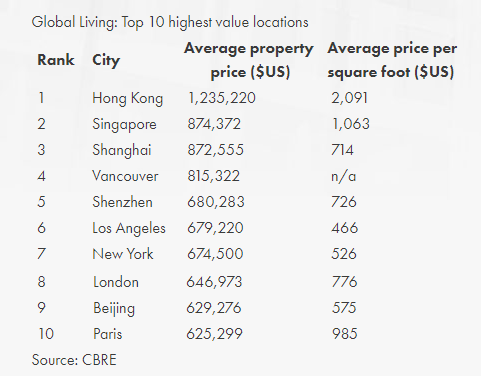

As such, housing prices may not be so accessible and house shopping is a big decision indeed. Hence we want to be wise when buying a property, be it for own stay or future investment. <br /><br />We want to investigate different drivers that may affect Singapore's HDB prices. Some possible drivers may be town locations of the HDB flats, proximity to public transport MRT train stations, distance from Central (Orchard). This analysis will hopefully provide some insights as well as consideration factors when buying or selling your properties. <br />

For the purpose of this project I have opted to do analysis and modelling on HDB flats (public housing) as the data is public and readily available, without having to spend a hefty sum on the private property sites for data but the techniques and analysis will follow in the similar fashion.

<h3>Data Required</h3>

* Resale HDB flat prices, as a proxy of property prices - this data set will include useful information including
    * town
    * flat type
    * size
    * street name
    * resale price
    * remaining lease
    * lease commencement date

From these, we will also be able to derive price per area, address, number of years remaining in the lease etc, which after some exploratory data analysis, we can use to determine which will be features in our model.

* Public transport - we will use a static list of public train service MRT stations for a simplified view.
* List of retail malls
* Geolocation coordinates for the above mentioned including HDB flats, MRT stations, retail malls

<h3>Data Sources</h3>

* Resale flat prices - https://data.gov.sg/
* Geolocation data - https://docs.onemap.sg/
* MRT Stations - https://en.wikipedia.org/wiki/List_of_Singapore_MRT_stations_by_planning_area
* Retail Shopping Malls - https://en.wikipedia.org/wiki/List_of_shopping_malls_in_Singapore

In [1]:
## install required libraries

!pip install geopy
!pip install missingno

In [2]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import missingno
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from geopy.distance import geodesic

<h2>Methodology</h2>

* Data gathering
* Data Preprocessing
* Exploratory Data Analysis

<h3>Data Gathering</h3>

We first get a list of resale price data via api call.

In [3]:
LIMIT = 5000 ## we dont want to overrload the api call

query_string='https://data.gov.sg/api/action/datastore_search?resource_id=42ff9cfe-abe5-4b54-beda-c88f9bb438ee&limit='+str(LIMIT)
resp = requests.get(query_string)
data = json.loads(resp.content)
len(data['result']['records'])

5000

In [4]:
hdb_price_dict_records = data['result']['records']

## stuff json into a dataframe
town = []
flat_type = []
flat_model = []
floor_area_sqm = []
street_name = []
resale_price = []
month = []
remaining_lease = []
lease_commence_date = []
storey_range = []
_id = []
block = []

for i in range(0, len(hdb_price_dict_records)):
    town.append(hdb_price_dict_records[i]['town'])
    flat_type.append(hdb_price_dict_records[i]['flat_type'])
    flat_model.append(hdb_price_dict_records[i]['flat_model'])
    floor_area_sqm.append(hdb_price_dict_records[i]['floor_area_sqm'])
    street_name.append(hdb_price_dict_records[i]['street_name'])
    resale_price.append(hdb_price_dict_records[i]['resale_price'])
    month.append(hdb_price_dict_records[i]['month'])
    remaining_lease.append(hdb_price_dict_records[i]['remaining_lease'])
    lease_commence_date.append(hdb_price_dict_records[i]['lease_commence_date'])
    storey_range.append(hdb_price_dict_records[i]['storey_range'])
    _id.append(hdb_price_dict_records[i]['_id'])
    block.append(hdb_price_dict_records[i]['block'])
    
df_hdb_price = pd.DataFrame({
    'town': town,
    'flat_type': flat_type,
    'flat_model': flat_model,
    'floor_area_sqm': floor_area_sqm,
    'street_name': street_name,
    'resale_price': resale_price,
    'month': month,
    'remaining_lease': remaining_lease,
    'lease_commence_date': lease_commence_date,
    'storey_range': storey_range,
    '_id': _id,
    'block': block
})

df_hdb_price.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,remaining_lease,lease_commence_date,storey_range,_id,block
0,JURONG EAST,4 ROOM,Model A2,90,TOH GUAN RD,398000,2017-01,80 years 10 months,1998,01 TO 03,1,283
1,JURONG EAST,4 ROOM,Model A,105,JURONG EAST ST 32,420000,2017-01,67 years 01 month,1985,10 TO 12,2,310
2,JURONG EAST,4 ROOM,Model A,104,JURONG EAST AVE 1,426000,2017-01,65 years 05 months,1983,07 TO 09,3,329
3,JURONG EAST,4 ROOM,Model A,104,JURONG EAST ST 32,450000,2017-01,66 years 07 months,1984,13 TO 15,4,312
4,JURONG EAST,4 ROOM,Model A,92,TEBAN GDNS RD,450000,2017-01,95 years 09 months,2013,19 TO 21,5,22


In [5]:
df_hdb_price.shape

(5000, 12)

In [6]:
## get a list of mrt train stations in Singapore - ref wiki

list_of_mrt = [
    'Admiralty MRT Station',
    'Aljunied MRT Station',
    'Ang Mo Kio MRT Station',
    'Bartley MRT Station',
    'Bayfront MRT Station',
    'Beauty World MRT Station',
    'Bedok MRT Station',
    'Bedok North MRT Station',
    'Bedok Reservoir MRT Station',
    'Bencoolen MRT Station',
    'Bendemeer MRT Station',
    'Bishan MRT Station',
    'Boon Keng MRT Station',
    'Boon Lay MRT Station',
    'Botanic Gardens MRT Station',
    'Braddell MRT Station',
    'Bras Basah MRT Station',
    'Buangkok MRT Station',
    'Bugis MRT Station',
    'Bukit Batok MRT Station',
    'Bukit Gombak MRT Station',
    'Bukit Panjang MRT Station',
    'Buona Vista MRT Station',
    'Caldecott MRT Station',
    'Canberra MRT Station',
    'Cashew MRT Station',
    'Changi Airport MRT Station',
    'Chinatown MRT Station',
    'Chinese Garden MRT Station',
    'Choa Chu Kang MRT Station',
    'City Hall MRT Station',
    'Clarke Quay MRT Station',
    'Clementi MRT Station',
    'Commonwealth MRT Station',
    'Dakota MRT Station',
    'Dhoby Ghaut MRT Station',
    'Dover MRT Station',
    'Downtown MRT Station',
    'Esplanade MRT Station',
    'Eunos MRT Station',
    'Expo MRT Station',
    'Farrer Park MRT Station',
    'Farrer Road MRT Station',
    'Fort Canning MRT Station',
    'Geylang Bahru MRT Station',
    'Gul Circle MRT Station',
    'HarbourFront MRT Station',
    'Haw Par Villa MRT Station',
    'Hillview MRT Station',
    'Holland Village MRT Station',
    'Hougang MRT Station',
    'Jalan Besar MRT Station',
    'Joo Koon MRT Station',
    'Jurong East MRT Station',
    'Kaki Bukit MRT Station',
    'Kallang MRT Station',
    'Kembangan MRT Station',
    'Kent Ridge MRT Station',
    'Khatib MRT Station',
    'King Albert Park MRT Station',
    'Kovan MRT Station',
    'Kranji MRT Station',
    'Labrador Park MRT Station',
    'Lakeside MRT Station',
    'Lavender MRT Station',
    'Little India MRT Station',
    'Lorong Chuan MRT Station',
    'MacPherson MRT Station',
    'Marina Bay MRT Station',
    'Marina South Pier MRT Station',
    'Marsiling MRT Station',
    'Marymount MRT Station',
    'Mattar MRT Station',
    'Mountbatten MRT Station',
    'Newton MRT Station',
    'Nicoll Highway MRT Station',
    'Novena MRT Station',
    'one-north MRT Station',
    'Orchard MRT Station',
    'Outram Park MRT Station',
    'Pasir Panjang MRT Station',
    'Pasir Ris MRT Station',
    'Paya Lebar MRT Station',
    'Pioneer MRT Station',
    'Potong Pasir MRT Station',
    'Promenade MRT Station',
    'Punggol MRT Station',
    'Queenstown MRT Station',
    'Raffles Place MRT Station',
    'Redhill MRT Station',
    'Rochor MRT Station',
    'Sembawang MRT Station',
    'Sengkang MRT Station',
    'Serangoon MRT Station',
    'Simei MRT Station',
    'Sixth Avenue MRT Station',
    'Somerset MRT Station',
    'Stadium MRT Station',
    'Stevens MRT Station',
    'Tai Seng MRT Station',
    'Tampines East MRT Station',
    'Tampines MRT Station',
    'Tampines West MRT Station',
    'Tan Kah Kee MRT Station',
    'Tanah Merah MRT Station',
    'Tanjong Pagar MRT Station',
    'Telok Ayer MRT Station',
    'Telok Blangah MRT Station',
    'Tiong Bahru MRT Station',
    'Toa Payoh MRT Station',
    'Tuas Crescent MRT Station',
    'Tuas Link MRT Station',
    'Tuas West Road MRT Station',
    'Ubi MRT Station',
    'Upper Changi MRT Station',
    'Woodlands MRT Station',
    'Woodleigh MRT Station',
    'Yew Tee MRT Station',
    'Yio Chu Kang MRT Station',
    'Yishun MRT Station'
]

In [7]:
list_of_shopping_mall = [
    '100 AM',
    '112 Katong',
    '313@Somerset',
    '321 Clementi',
    '888 Plaza',
    'Admiralty Place',
    'Alexandra Central',
    'Alexandra Retail Centre',
    'AMK Hub',
    'Anchorpoint',
    'Aperia',
    'Balestier Hill Shopping Centre',
    'Beauty World Centre',
    'Beauty World Plaza',
    'Bedok Mall',
    'Bedok Point',
    'Big Box',
    'Boon Lay Shopping Centre',
    'Broadway Plaza',
    'Buangkok Square',
    'Bugis Cube',
    'Bugis Junction',
    'Bugis+',
    'Bukit Panjang Plaza',
    'Bukit Timah Plaza',
    'Capitol Piazza',
    'Cathay Cineleisure Orchard',
    'Causeway Point',
    'Century Square',
    'Changi Airport',
    'Changi City Point',
    'City Gate',
    'City Plaza',
    'City Square Mall',
    'CityLink Mall',
    'Clarke Quay Central',
    'Compass One',
    'Djitsun Mall',
    'Djitsun Mall Bedok',
    'Downtown East',
    'Duo',
    'East Village',
    'Eastpoint Mall',
    'Elias Mall',
    'Fairprice Hub',
    'Fajar Shopping Centre',
    'Far East Plaza',
    'Funan',
    'Gek Poh Shopping Centre',
    'Grantral Mall',
    'Great World City',
    'Greenridge Shopping Centre',
    'Greenwich V',
    'HarbourFront Centre',
    'HDB Hub',
    'Heartland Mall',
    'Hillion Mall',
    'HillV2',
    'Holland Village Shopping Mall',
    'Hougang 1',
    'Hougang Green Shopping Mall',
    'Hougang Mall',
    'IMM',
    'ION Orchard',
    'JCube',
    'Jem',
    'Jubilee Square',
    'Junction 10',
    'Junction 8',
    'Junction 9',
    'Jurong Point',
    'Kallang Wave Mall',
    'Katong Square',
    'Katong V',
    'Keat Hong Shopping Centre',
    'KKH The Retail Mall',
    'Knightsbridge[1]',
    'Leisure Park Kallang',
    'Liang Court',
    'Liat Towers',
    'Limbang Shopping Centre',
    'Lot One',
    'Loyang Point',
    'Lucky Plaza',
    'Marina Bay Financial Centre Tower 3',
    'Marina Bay Link Mall',
    'Marina Bay Sands',
    'Marina One',
    'Marina Square',
    'Marsiling Mall',
    'Midpoint Orchard',
    'Millenia Walk',
    'Mustafa Shopping Centre',
    'myVillage @ Serangoon',
    'NEX',
    'Ngee Ann City',
    'North East',
    'North West',
    'Northpoint City',
    'Oasis Terraces',
    'OD Mall',
    'Orchard Central',
    'Orchard Gateway',
    'Orchard Plaza',
    'Orchard Shopping Centre',
    'Our Tampines Hub',
    'Palais Renaissance',
    'Parkway Parade',
    'Paya Lebar Square',
    'Peoples Park Centre',
    'Peoples Park Complex',
    'Pioneer Mall',
    'Plaza Singapura',
    'PLQ Mall',
    'PoMo',
    'Punggol Plaza',
    'Queensway Shopping Centre',
    'Raffles City',
    'Rail Mall',
    'Rivervale Mall',
    'Rivervale Plaza',
    'Rochester Mall',
    'Scotts Square',
    'Sembawang Shopping Centre',
    'Serangoon Plaza',
    'Shaw House and Centre',
    'Sim Lim Square',
    'Singapore Post Centre',
    'Singapore Shopping Centre',
    'Square 2',
    'Sun Plaza',
    'Sunshine Place',
    'Suntec City',
    'Taman Jurong Shopping Centre',
    'Tampines 1',
    'Tampines Mall',
    'Tanglin Mall',
    'Tangs',
    'Tanjong Pagar Centre',
    'Teck Whye Shopping Centre',
    'Tekka Centre',
    'The Centrepoint',
    'The Clementi Mall',
    'The Flow',
    'The Midtown',
    'The Paragon',
    'The Poiz [2]',
    'The Seletar Mall',
    'The Shoppes at Marina Bay Sands',
    'The South Beach',
    'The Star Vista',
    'Thomson Plaza',
    'Tiong Bahru Plaza',
    'United Square, The Kids Learning Mall',
    'Upper Serangoon Shopping Centre',
    'Velocity',
    'VivoCity',
    'Waterway Point',
    'West Coast Plaza',
    'West Mall',
    'Westgate Mall',
    'Wheelock Place',
    'White Sands',
    'Wisma Atria',
    'Wisteria Mall',
    'Woodlands Mart',
    'Yew Tee Point',
    'Yew Tee Shopping Centre',
    'Yew Tee Square',
    'Zhongshan Mall'
]

We are still in the data gathering stage. Based on the list of the MRT train stations and Retail Shopping Malls from above, we now want to fill the data set with their geolocation / coordinates via the OneMap api call. This step is important for our proximity calculations.

In [8]:
## using OneMap Api to get coords for mrt and malls for analysis
mrt_lat = []
mrt_long = []

for i in range(0, len(list_of_mrt)):
    query_address = list_of_mrt[i]
    query_string = 'https://developers.onemap.sg/commonapi/search?searchVal='+str(query_address)+'&returnGeom=Y&getAddrDetails=Y'
    resp = requests.get(query_string)

    data_mrt=json.loads(resp.content)
    
    if data_mrt['found'] != 0:
        mrt_lat.append(data_mrt["results"][0]["LATITUDE"])
        mrt_long.append(data_mrt["results"][0]["LONGITUDE"])

        print (str(query_address)+", Lat: "+data_mrt['results'][0]['LATITUDE'] +", Long: "+data_mrt['results'][0]['LONGITUDE'])

    else:
        mrt_lat.append('NotFound')
        mrt_lat.append('NotFound')
        print ("No Results")

# Store this information in a dataframe
mrt_location = pd.DataFrame({
    'MRT': list_of_mrt,
    'Latitude': mrt_lat,
    'Longitude': mrt_long
})

mrt_location.head()

Admiralty MRT Station, Lat: 1.44034337155075, Long: 103.800984160903
Aljunied MRT Station, Lat: 1.31623848507354, Long: 103.882496650859
Ang Mo Kio MRT Station, Lat: 1.36993284962264, Long: 103.849558091776
Bartley MRT Station, Lat: 1.34244543829251, Long: 103.88019708711701
Bayfront MRT Station, Lat: 1.28283490852293, Long: 103.85959687246401
Beauty World MRT Station, Lat: 1.3409014900143101, Long: 103.77574671777799
Bedok MRT Station, Lat: 1.32408493878949, Long: 103.929397331362
Bedok North MRT Station, Lat: 1.3341747014815901, Long: 103.919055366359
Bedok Reservoir MRT Station, Lat: 1.33658348325379, Long: 103.933489354839
Bencoolen MRT Station, Lat: 1.29920140046324, Long: 103.850838318577
Bendemeer MRT Station, Lat: 1.3134960445548798, Long: 103.863213831657
Bishan MRT Station, Lat: 1.35101889777846, Long: 103.85005720860799
Boon Keng MRT Station, Lat: 1.3199395765329098, Long: 103.862052698446
Boon Lay MRT Station, Lat: 1.33828431080458, Long: 103.705405450881
Botanic Gardens MR

,MRT,Latitude,Longitude
0,Admiralty MRT Station,1.44034337155075,103.800984160903
1,Aljunied MRT Station,1.31623848507354,103.882496650859
2,Ang Mo Kio MRT Station,1.36993284962264,103.849558091776
3,Bartley MRT Station,1.34244543829251,103.88019708711701
4,Bayfront MRT Station,1.28283490852293,103.85959687246401


In [9]:
# Retrieve Shopping Mall Coordinates
mall_name = []
mall_roadname = []
mall_lat = []
mall_long = []

for i in range(0, len(list_of_shopping_mall)):
    query_address = list_of_shopping_mall[i]
    query_string = 'https://developers.onemap.sg/commonapi/search?searchVal='+str(query_address)+'&returnGeom=Y&getAddrDetails=Y'
    resp = requests.get(query_string)
    data_mall=json.loads(resp.content)
    
    if data_mall['found'] != 0:
        mall_name.append(query_address)
        mall_roadname.append(data_mall["results"][0]["ROAD_NAME"])
        mall_lat.append(data_mall["results"][0]["LATITUDE"])
        mall_long.append(data_mall["results"][0]["LONGITUDE"])

        print (str(query_address)+", Lat: "+data_mall['results'][0]['LATITUDE'] +", Long: "+data_mall['results'][0]['LONGITUDE'])

    else:
        print ("No Results")

# Store coords in a dataframe
mall_location = pd.DataFrame({
    'Mall': mall_name,
    'RoadName': mall_roadname,
    'Latitude': mall_lat,
    'Longitude': mall_long
})

mall_location.head()

100 AM, Lat: 1.27458821795427, Long: 103.84347073660999
112 Katong, Lat: 1.30508681845447, Long: 103.905098915055
313@Somerset, Lat: 1.30100656917243, Long: 103.838246592796
321 Clementi, Lat: 1.3120249182444, Long: 103.764960537008
888 Plaza, Lat: 1.4371305244487, Long: 103.795289911954
Admiralty Place, Lat: 1.43988095490574, Long: 103.80179101959499
Alexandra Central, Lat: 1.28745612377701, Long: 103.80541465201401
Alexandra Retail Centre, Lat: 1.2741489362925602, Long: 103.801399416665
AMK Hub, Lat: 1.3693892271771801, Long: 103.848477965668
Anchorpoint, Lat: 1.28893477974498, Long: 103.805607779399
Aperia, Lat: 1.3097424203235601, Long: 103.864101647509
Balestier Hill Shopping Centre, Lat: 1.32612416875662, Long: 103.843709493566
Beauty World Centre, Lat: 1.3424126418864297, Long: 103.776539385678
Beauty World Plaza, Lat: 1.34178799847022, Long: 103.776304121109
Bedok Mall, Lat: 1.3246689739690902, Long: 103.92940545649
Bedok Point, Lat: 1.32480102552269, Long: 103.932384005117
Big

,Mall,RoadName,Latitude,Longitude
0,100 AM,TRAS STREET,1.27458821795427,103.84347073660999
1,112 Katong,EAST COAST ROAD,1.30508681845447,103.905098915055
2,313@Somerset,ORCHARD ROAD,1.30100656917243,103.838246592796
3,321 Clementi,CLEMENTI AVENUE 3,1.3120249182444,103.764960537008
4,888 Plaza,WOODLANDS DRIVE 50,1.4371305244487,103.795289911954


In [10]:
# To find the geolocation of each unit that was transacted -- combine the block and street name for address
df_hdb_price['address'] = df_hdb_price['block'] + " " + df_hdb_price['street_name']
len(df_hdb_price)

5000

In [11]:
# Checking for and removing duplicates
df_dedup = df_hdb_price.drop_duplicates(subset='address', keep='first')
len(df_dedup)

2364

In [12]:
# Next let's grab the unique addresses and create a list 
address_list = df_dedup['address'].tolist()
len(address_list)

2364

In [ ]:
## fitting the address list above and joining the coordinates to the same data

latitude = []
longitude = []
blk_no = []
road_name = []
postal_code = []
address = []
count = 0

for row in range(len(address_list)):
    #formulate query string  
    query_address = address_list[row]
    query_string='https://developers.onemap.sg/commonapi/search?searchVal='+str(query_address)+'&returnGeom=Y&getAddrDetails=Y'
    resp = requests.get(query_string)          

    #Convert JSON into Python Object 
    data_geo_location=json.loads(resp.content)
    if data_geo_location['found'] != 0:
        latitude.append(data_geo_location['results'][0]['LATITUDE'])
        longitude.append(data_geo_location['results'][0]['LONGITUDE'])
        blk_no.append(data_geo_location['results'][0]['BLK_NO'])
        road_name.append(data_geo_location['results'][0]['ROAD_NAME'])
        postal_code.append(data_geo_location['results'][0]['POSTAL'])
        address.append(query_address)
        print (str(query_address) + ", Lat: " + data_geo_location['results'][0]['LATITUDE'] + ", Long: " + data_geo_location['results'][0]['LONGITUDE'])
    else:
        print ("No Results")

In [14]:
# Fit into a dataframe
df_coordinates = pd.DataFrame({
    'latitude': latitude,
    'longitude': longitude,
    'blk_no': blk_no,
    'road_name': road_name,
    'postal_code': postal_code,
    'address': address
})

df_coordinates.shape

(2361, 6)

In [15]:
list_of_lat = df_coordinates['latitude']
list_of_long = df_coordinates['longitude']

# Coordinates of all addresses
list_of_coordinates = []
for lat, long in zip(list_of_lat, list_of_long):
    list_of_coordinates.append((lat,long))
    
len(list_of_coordinates)

2361

In [16]:
# similar process to get MRT Train stations coordinates
mrt_lat = mrt_location['Latitude']
mrt_long = mrt_location['Longitude']

list_of_mrt_coordinates = []

for lat, long in zip(mrt_lat, mrt_long):
    list_of_mrt_coordinates.append((lat, long))
    
len(list_of_mrt_coordinates)

120

In [17]:
# and for Shopping malls
mall_lat = mall_location['Latitude']
mall_long = mall_location['Longitude']

list_of_mall_coordinates = []

for lat, long in zip(mall_lat, mall_long):
    list_of_mall_coordinates.append((lat, long))
    
len(list_of_mall_coordinates)

155

Next comes the minimum distance calculations.

In [18]:
# getting min distance to mrt train stations
list_of_dist_mrt = []
min_dist_mrt = []

for origin in list_of_coordinates:
    for destination in range(0, len(list_of_mrt_coordinates)):
        list_of_dist_mrt.append(geodesic(origin,list_of_mrt_coordinates[destination]).meters)
    shortest = (min(list_of_dist_mrt))
    min_dist_mrt.append(shortest)
    list_of_dist_mrt.clear()

In [19]:
# getting min distance to shopping malls
list_of_dist_mall = []
min_dist_mall = []

for origin in list_of_coordinates:
    for destination in range(0, len(list_of_mall_coordinates)):
        list_of_dist_mall.append(geodesic(origin,list_of_mall_coordinates[destination]).meters)
    shortest = (min(list_of_dist_mall))
    print(shortest)
    min_dist_mall.append(shortest)
    list_of_dist_mall.clear()

464.3341076696399
1708.209293579854
1987.637586725472
1755.8821765138857
1155.023285666859
681.0510973890395
810.3146196046836
793.3636520476126
689.9297468102378
1584.8495590162565
1490.9990200310292
797.2312559886354
1671.2299220213877
1053.204852302674
1367.8985107193007
732.9952628004761
741.4404268352276
188.74583373973314
475.74424788918253
343.6901966443257
470.4738865545745
290.2757251807818
427.3359730107306
1007.2601084113421
1708.6750626468088
1190.6270958695318
1019.7794428755802
879.3510247244067
274.4944742012465
922.4527283923557
410.0222743875392
629.0280617101456
807.5732532293338
879.3236969080912
539.0372128444477
410.6929056552585
182.80965675894274
229.1683106087776
773.6214830307505
419.9879026115772
291.72930765774606
669.6146170401042
882.5132793201506
635.1263803429865
309.80566167549847
144.70189158080356
719.1259294946408
837.6612171340631
816.5779694940246
380.11698785422635
723.4070361208727
708.10354241171
165.54429160882813
131.73500845050873
277.25197477

In [20]:
# distance from Central Singapore - Orchard Road
orchard_dist_lat = 1.304833
orchard_dist_long = 103.831833
orchard_dist = []

for origin in list_of_coordinates:
    orchard_dist.append(geodesic(origin,(orchard_dist_lat, orchard_dist_long)).meters)

Finally we have the dataset we want to work with.

In [21]:
# getting master dataset

df_coordinates['min_dist_mrt'] = min_dist_mrt
df_coordinates['min_dist_mall'] = min_dist_mall
df_coordinates['orchard_dist'] = orchard_dist

df_coordinates.head()

,latitude,longitude,blk_no,road_name,postal_code,address,min_dist_mrt,min_dist_mall,orchard_dist
0,1.33908506817906,103.74705803294,283,TOH GUAN ROAD,600283,283 TOH GUAN RD,816.093559,464.334108,10166.435956
1,1.3482083630536899,103.73379934220301,310,JURONG EAST STREET 32,600310,310 JURONG EAST ST 32,661.383173,1708.209294,11917.851375
2,1.35013988623411,103.729936587391,329,JURONG EAST AVENUE 1,600329,329 JURONG EAST AVE 1,888.586541,1987.637587,12397.357148
3,1.3469146453725902,103.73217427385401,312,JURONG EAST STREET 32,600312,312 JURONG EAST ST 32,494.721982,1755.882177,12027.571353
4,1.32277239024453,103.739714299254,22,TEBAN GARDENS ROAD,600022,22 TEBAN GDNS RD,1262.633975,1155.023286,10442.073521


<h3>Data Pre-processing</h3>

In [22]:
# merging with our hdb dataset
combined = df_coordinates.merge(df_hdb_price, on="address", how='outer')

combined['resale_price'] = combined['resale_price'].astype('float')
combined['floor_area_sqm'] = combined['floor_area_sqm'].astype('float')
combined['lease_commence_date'] = combined['lease_commence_date'].astype('int64')
combined['lease_remain_years'] = 2020 - combined['lease_commence_date']
combined.columns

Index(['latitude', 'longitude', 'blk_no', 'road_name', 'postal_code',
       'address', 'min_dist_mrt', 'min_dist_mall', 'orchard_dist', 'town',
       'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'remaining_lease', 'lease_commence_date',
       'storey_range', '_id', 'block', 'lease_remain_years'],
      dtype='object')

In [23]:
combined.dropna(inplace=True)
combined['price_per_sqm'] = combined['resale_price'].div(combined['floor_area_sqm'])

In [24]:
# We want to do some more exploratory data analysis on the HDB dataset
# check that input is pandas dataframe
if type(combined) != pd.core.frame.DataFrame:
    raise TypeError("Only pandas dataframe is allowed as input")
   
# replace field that's entirely space (or empty) with NaN
combined = combined.replace(r'^\s*$', np.nan, regex=True)
print("Preview of data:")
display(combined.head(3))

print("\nTo check: \n (1) Total number of entries \n (2) Column types \n (3) Any null values\n")
print(combined.info())


Preview of data:


,latitude,longitude,blk_no,road_name,postal_code,address,min_dist_mrt,min_dist_mall,orchard_dist,town,...,street_name,resale_price,month,remaining_lease,lease_commence_date,storey_range,_id,block,lease_remain_years,price_per_sqm
0,1.33908506817906,103.74705803294,283,TOH GUAN ROAD,600283,283 TOH GUAN RD,816.093559,464.334108,10166.435956,JURONG EAST,...,TOH GUAN RD,398000.0,2017-01,80 years 10 months,1998,01 TO 03,1,283,22,4422.222222
1,1.33908506817906,103.74705803294,283,TOH GUAN ROAD,600283,283 TOH GUAN RD,816.093559,464.334108,10166.435956,JURONG EAST,...,TOH GUAN RD,398000.0,2017-01,80 years 10 months,1998,01 TO 03,951,283,22,4422.222222
2,1.33908506817906,103.74705803294,283,TOH GUAN ROAD,600283,283 TOH GUAN RD,816.093559,464.334108,10166.435956,JURONG EAST,...,TOH GUAN RD,423000.0,2017-02,80 years 09 months,1998,04 TO 06,2328,283,22,4548.387097



To check: 
 (1) Total number of entries 
 (2) Column types 
 (3) Any null values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4990 entries, 0 to 4989
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   latitude             4990 non-null   object 
 1   longitude            4990 non-null   object 
 2   blk_no               4990 non-null   object 
 3   road_name            4990 non-null   object 
 4   postal_code          4990 non-null   object 
 5   address              4990 non-null   object 
 6   min_dist_mrt         4990 non-null   float64
 7   min_dist_mall        4990 non-null   float64
 8   orchard_dist         4990 non-null   float64
 9   town                 4990 non-null   object 
 10  flat_type            4990 non-null   object 
 11  flat_model           4990 non-null   object 
 12  floor_area_sqm       4990 non-null   float64
 13  street_name          4990 non-null   object 
 14  resal

From the data, we want to clean it up for further analysis.

In [25]:
## clean up dataset

# set as numerical
#combined['resale_price'] = combined['resale_price'].astype('float64')
combined['floor_area_sqm'] = combined['floor_area_sqm'].astype('float64')
combined['lease_commence_date'] = combined['lease_commence_date'].astype('int64')


# set categorical data
combined['town'] = combined['town'].astype('category')
combined['flat_type'] = combined['flat_type'].astype('category')
combined['storey_range'] = combined['storey_range'].astype('category')

# set datetime data
combined['month'] = pd.to_datetime(combined['month'])


# set as string
combined['street_name'] = combined['street_name'].astype('str')
combined['remaining_lease'] = combined['remaining_lease'].astype('str')

## set as string to exclude from numerical analysis
combined['_id'] = combined['_id'].astype('str')
combined['resale_price'] = combined['resale_price'].astype('str')
combined['flat_model'] = combined['flat_model'].astype('str')


print(combined.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4990 entries, 0 to 4989
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   latitude             4990 non-null   object        
 1   longitude            4990 non-null   object        
 2   blk_no               4990 non-null   object        
 3   road_name            4990 non-null   object        
 4   postal_code          4990 non-null   object        
 5   address              4990 non-null   object        
 6   min_dist_mrt         4990 non-null   float64       
 7   min_dist_mall        4990 non-null   float64       
 8   orchard_dist         4990 non-null   float64       
 9   town                 4990 non-null   category      
 10  flat_type            4990 non-null   category      
 11  flat_model           4990 non-null   object        
 12  floor_area_sqm       4990 non-null   float64       
 13  street_name          4990 non-nul

In [26]:
# generate preview of entries with null values
if len(combined[combined.isnull().any(axis=1)] != 0):
    print("\nPreview of data with null values:")
    display(combined[combined.isnull().any(axis=1)].head(3))
    missingno.matrix(combined)
    plt.show()
else:
    print("\nNo null values found")


No null values found


For the current dataset, we don't have any null values; else we will need to review the data for some clean-up before proceeding with analysis.

In [27]:
# generate count statistics of duplicate entries
if len(combined[combined.duplicated()]) > 0:
    print("\n***Number of duplicated entries: ", len(combined[combined.duplicated()]))
    display(combined[combined.duplicated(keep=False)].sort_values(by=list(combined.columns)).head())
else:
    print("\nNo duplicated entries found")


No duplicated entries found


In this case, we don't have any duplicate entries; otherwise we will need to deduplicate the dataset. See the following code:

In [28]:
combined.drop_duplicates(inplace=True)

In [29]:
print("\nTo check: \nUnique count of non-numeric data\n")
print(combined.select_dtypes(include=['object', 'category']).nunique())


To check: 
Unique count of non-numeric data

latitude           2361
longitude          2361
blk_no             1204
road_name           455
postal_code        2361
address            2361
town                 26
flat_type             6
flat_model           14
street_name         454
resale_price        582
remaining_lease     475
storey_range         16
_id                4990
block              1166
dtype: int64


<h3>Exploratory Data Analysis</h3>

In [30]:
## columns = combined.select_dtypes(include=['object', 'category']).columns
columns = combined.select_dtypes(include=['category']).columns
for col in columns:
    print("Top 5 unique values of " + col)
    print(combined[col].value_counts().reset_index().rename(columns={"index": col, col: "Count"})[
          :min(5, len(combined[col].value_counts()))])
    print(" ")

Top 5 unique values of town
          town  Count
0        BEDOK    417
1  JURONG WEST    363
2     SENGKANG    330
3   ANG MO KIO    318
4    WOODLANDS    314
 
Top 5 unique values of flat_type
   flat_type  Count
0     4 ROOM   2016
1     3 ROOM   1358
2     5 ROOM   1158
3  EXECUTIVE    393
4     2 ROOM     63
 
Top 5 unique values of storey_range
  storey_range  Count
0     04 TO 06   1192
1     07 TO 09   1102
2     10 TO 12    990
3     01 TO 03    897
4     13 TO 15    413
 


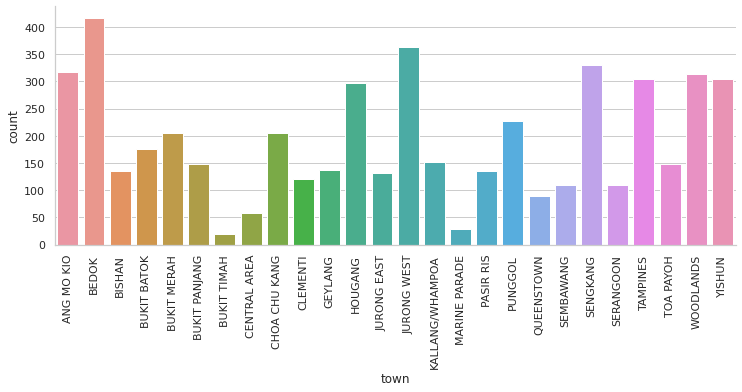

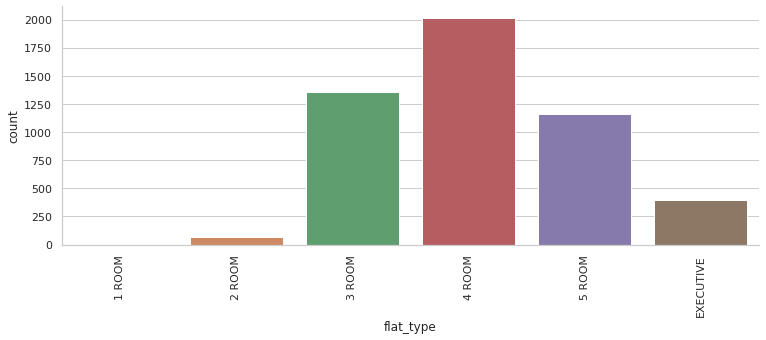

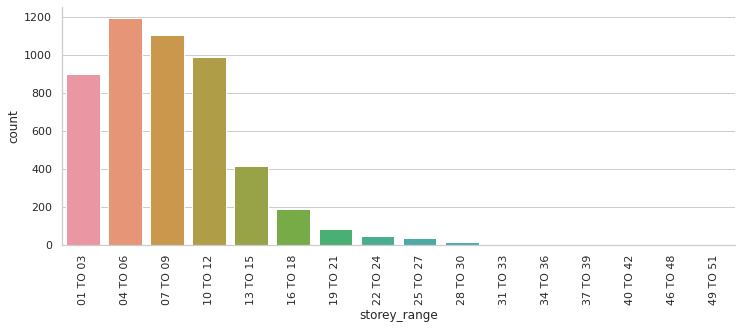

In [31]:
# Plot count distribution of categorical data

sns.set(style="whitegrid")
for col in combined.select_dtypes(include=['category']).columns:
    fig = sns.catplot(x=col, kind="count", data=combined, hue=None)
    fig.set_xticklabels(rotation=90)
    fig = plt.gcf()
    fig.set_size_inches(12,4)
    plt.show()

With the above visualizations, we have a better idea of the data distribution across categories, and which categories will be used for our features.


To check: 
Distribution of numeric data


,count,mean,std,min,25%,50%,75%,max
min_dist_mrt,4990.0,743.753814,419.991431,21.879464,440.163441,657.286917,935.855968,3605.171617
min_dist_mall,4990.0,677.339842,388.264828,0.000030,396.522468,600.860068,885.484833,3502.101533
orchard_dist,4990.0,10626.123120,3901.780958,1456.287304,7648.795903,11285.010588,13833.548088,19593.855652
floor_area_sqm,4990.0,96.715551,24.305697,31.000000,74.000000,95.000000,113.000000,192.000000
lease_commence_date,4990.0,1991.302204,11.442364,1966.000000,1983.000000,1989.000000,2000.000000,2013.000000
lease_remain_years,4990.0,28.697796,11.442364,7.000000,20.000000,31.000000,37.000000,54.000000
price_per_sqm,4990.0,4587.788525,1096.576125,2760.683761,3866.666667,4345.974882,4983.606557,10552.380952


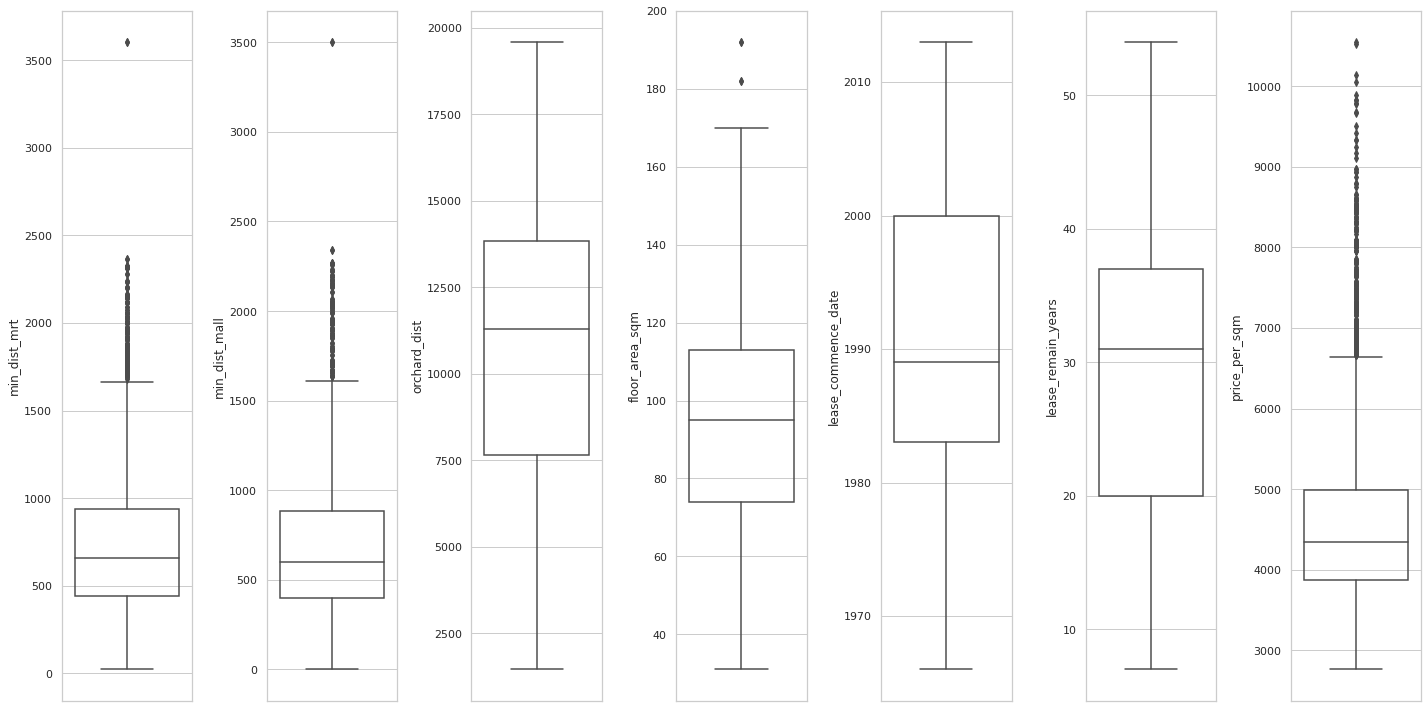

In [32]:
print("\nTo check: \nDistribution of numeric data")
display(combined.describe().T)
columns = combined.select_dtypes(include=np.number).columns
figure = plt.figure(figsize=(20, 10))
figure.add_subplot(1, len(columns), 1)
for index, col in enumerate(columns):
    if index > 0:
        figure.add_subplot(1, len(columns), index + 1)
    sns.boxplot(y=col, data=combined, boxprops={'facecolor': 'None'})
figure.tight_layout()
plt.show()

* Generally, numbers look good, no negative; if not we will need to do some investigation, and further cleaning since these numberical values of Resale Prices and Floor Area cannot possibly ne negative.
* Look at the Resale Price's max value - it is way over the 75 percentile (2.5x more), implying outliers are highly likely to be present.
* The boxplot of Resale Price further confirms outliers, although we do know in real estate, there may be volatile and wide swing of prices due to many factors.

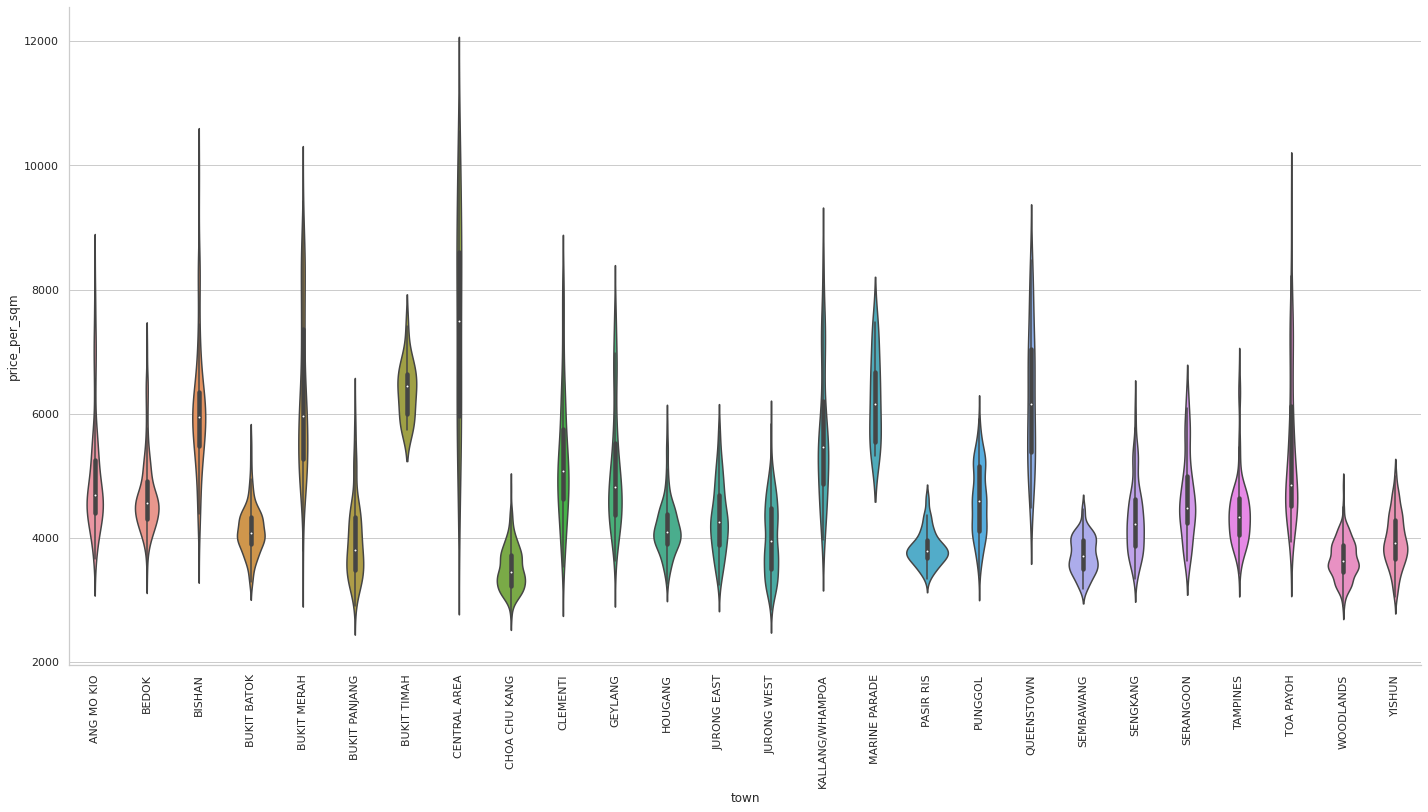

In [38]:
fig = sns.catplot(x='town', y='price_per_sqm', kind='violin', data=combined, height=10, aspect=2)
fig.set_xticklabels(rotation=90)
plt.show()

The above violin plots for price per sqm for each town highlights the Central Area has a very large variance in pricing, and a higher than average median price, with low probablity throughout the price range. On the other end, we can see towns such as Pasir Ris and Choa Chu Kang have lower variance and much lower median prices which higher probablity around the media prices.

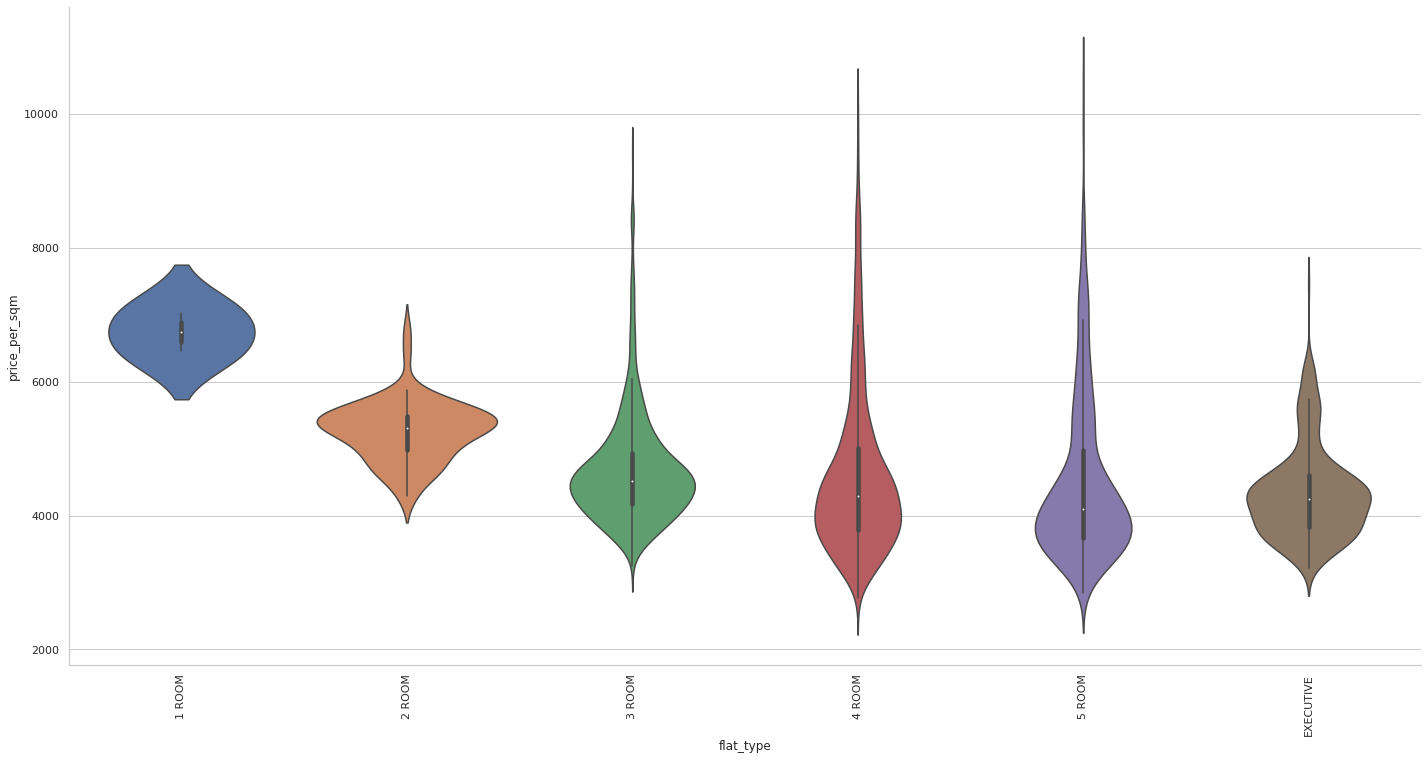

In [34]:
fig = sns.catplot(x='flat_type', y='price_per_sqm', kind='violin', data=combined, height=10, aspect=2)
fig.set_xticklabels(rotation=90)
plt.show()

Most outliers in 5 rooms flats wherre they are view as premium and are typically thriving in a seller's market. The converse is true in the case of 2-Room flat. The variance of the price is close to the median. In the case of the 2 Room flats, the median for prices per sqm is much higher than the others, presumably due to the much smaller overall quantum. The Median price per sqm for the other flat types hover around the same levels.

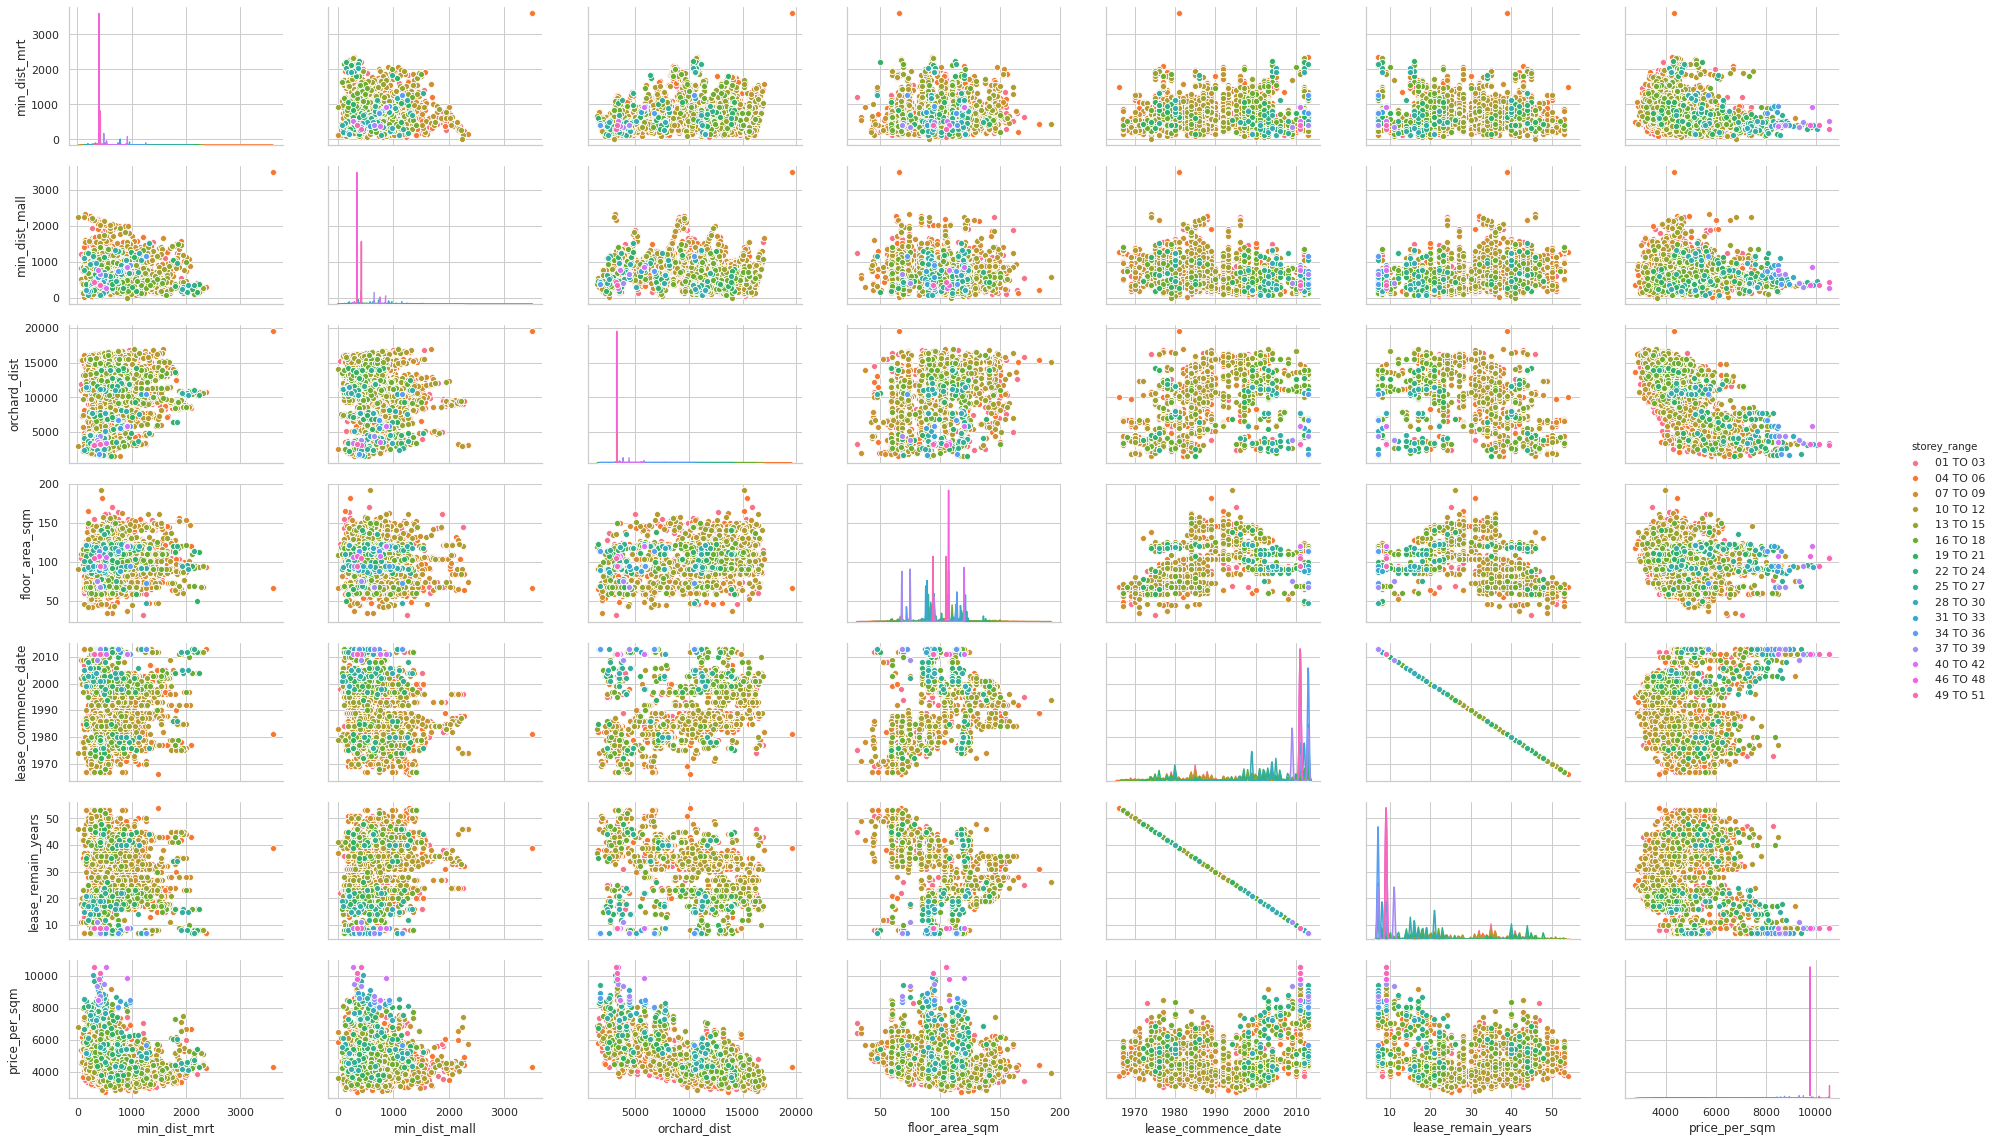

In [37]:
# Plot the pairwise joint distributions
sns.pairplot(combined.select_dtypes(include=np.number).join(combined[['storey_range']]), hue='storey_range',diag_kws={'bw': 0.2})
fig = plt.gcf()
fig.set_size_inches(28,16)
plt.show()

From the pair plots, we don't see much correlation by storey range. This may not be a good predictor. Let us investigate by flat type

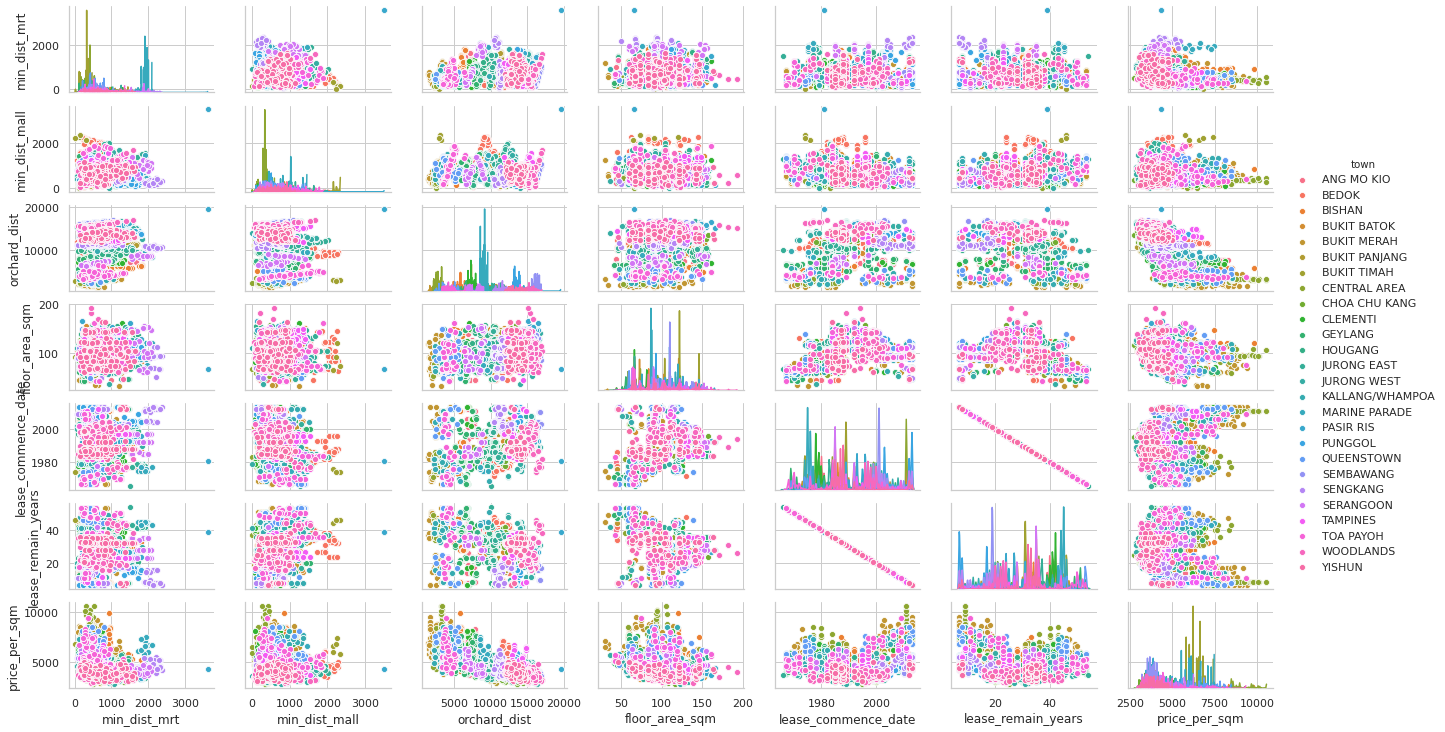

In [39]:
sns.pairplot(combined.select_dtypes(include=np.number).join(combined[['town']]), hue='town',diag_kws={'bw': 0.2})
fig = plt.gcf()
fig.set_size_inches(20,10)
plt.show()

From the above, we can see there may be a correlation (negative) between price per sqm vs distance from Orchard (Central) area, and remaining years on the lease. To a less extent, there seems to be some correlation between the price as well as proximity to  MRTs and Retail malls as well.

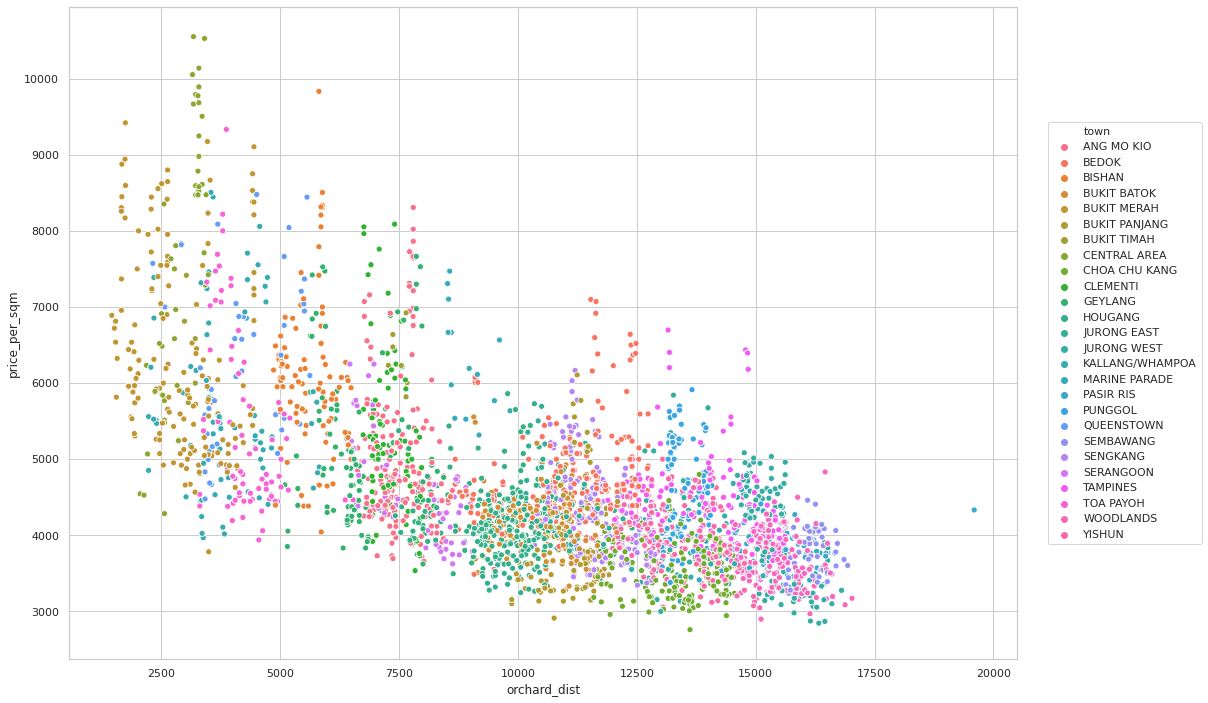

In [40]:
## scatter plot visualization

fig, ax1 = plt.subplots(1,1, figsize=(20,12))
g = sns.scatterplot(x=combined['orchard_dist'],y=combined['price_per_sqm'], hue=combined['town'], ax=ax1) 
box = g.get_position()
g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position
g.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), ncol=1)

plt.show()

In [41]:
# correlation between features i.e. nearest mrt, shopping mall,  distance from central, resale price, unit price per sqm
df_numerical_cols = combined[['min_dist_mrt', 'min_dist_mall', 'orchard_dist','floor_area_sqm', 'lease_remain_years', 'resale_price', 'price_per_sqm']]
df_numerical_cols.describe().round(0)

,min_dist_mrt,min_dist_mall,orchard_dist,floor_area_sqm,lease_remain_years,price_per_sqm
count,4990.0,4990.0,4990.0,4990.0,4990.0,4990.0
mean,744.0,677.0,10626.0,97.0,29.0,4588.0
std,420.0,388.0,3902.0,24.0,11.0,1097.0
min,22.0,0.0,1456.0,31.0,7.0,2761.0
25%,440.0,397.0,7649.0,74.0,20.0,3867.0
50%,657.0,601.0,11285.0,95.0,31.0,4346.0
75%,936.0,885.0,13834.0,113.0,37.0,4984.0
max,3605.0,3502.0,19594.0,192.0,54.0,10552.0


In [42]:
df_numerical_cols.dropna() ##(inplace=True)
df_numerical_cols.isna().sum()

min_dist_mrt          0
min_dist_mall         0
orchard_dist          0
floor_area_sqm        0
lease_remain_years    0
resale_price          0
price_per_sqm         0
dtype: int64

<AxesSubplot:>

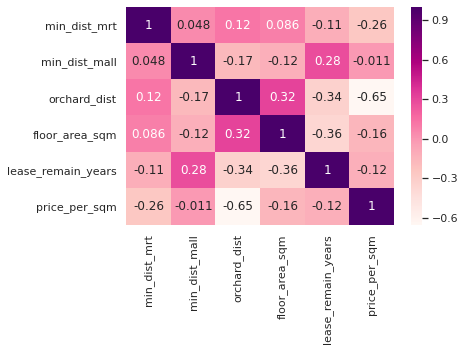

In [43]:
# corr matrix

corrMatrix = df_numerical_cols.corr()
sns.heatmap(corrMatrix, 
        xticklabels=corrMatrix.columns,
        yticklabels=corrMatrix.columns,
        cmap='RdPu',
        annot=True)

From the above we can see some good features, or predictors of price per sqm will be 

* distance from orchard
* distance from MRT

While distance from malls, or number of remaining lease in years does not seem to play a huge part in the property prices.

In [44]:
# Separate our numerical and categorical variables
cat_features = ['town', 'flat_type', 'storey_range']
num_features = ['min_dist_mrt', 'min_dist_mall', 'orchard_dist','floor_area_sqm', 'lease_remain_years', 'resale_price', 'price_per_sqm']
target = ['resale_price']

df_reg = combined[['town', 'flat_type', 'storey_range', 'min_dist_mrt', 'min_dist_mall', 'orchard_dist','floor_area_sqm', 'lease_remain_years', 'resale_price', 'price_per_sqm']]
df_reg['flat_type'].value_counts()

4 ROOM       2016
3 ROOM       1358
5 ROOM       1158
EXECUTIVE     393
2 ROOM         63
1 ROOM          2
Name: flat_type, dtype: int64

In [45]:
# Reference mapping categories for types of flats
flat_type_map = {
    'EXECUTIVE': 7,
    'MULTI-GENERATION': 6,
    '5 ROOM': 5,
    '4 ROOM': 4,
    '3 ROOM': 3,
    '2 ROOM': 2,
    '1 ROOM': 1
}

df_reg['flat_type_mapped'] = df_reg['flat_type'].map(lambda x: flat_type_map[x])
df_reg.head()

,town,flat_type,storey_range,min_dist_mrt,min_dist_mall,orchard_dist,floor_area_sqm,lease_remain_years,resale_price,price_per_sqm,flat_type_mapped
0,JURONG EAST,4 ROOM,01 TO 03,816.093559,464.334108,10166.435956,90.0,22,398000.0,4422.222222,4
1,JURONG EAST,4 ROOM,01 TO 03,816.093559,464.334108,10166.435956,90.0,22,398000.0,4422.222222,4
2,JURONG EAST,4 ROOM,04 TO 06,816.093559,464.334108,10166.435956,93.0,22,423000.0,4548.387097,4
3,JURONG EAST,4 ROOM,04 TO 06,816.093559,464.334108,10166.435956,93.0,22,423000.0,4548.387097,4
4,JURONG EAST,4 ROOM,10 TO 12,661.383173,1708.209294,11917.851375,105.0,35,420000.0,4000.000000,4


In [46]:
df_reg['storey_range'].value_counts()

04 TO 06    1192
07 TO 09    1102
10 TO 12     990
01 TO 03     897
13 TO 15     413
16 TO 18     191
19 TO 21      83
22 TO 24      47
25 TO 27      34
28 TO 30      14
34 TO 36       7
31 TO 33       7
40 TO 42       5
37 TO 39       5
49 TO 51       2
46 TO 48       1
Name: storey_range, dtype: int64

In [47]:
def split_mean(x):
    split_list = x.split(' TO ')
    mean = (float(split_list[0])+float(split_list[1]))/2
    return mean

df_reg['storey_mean'] = df_reg['storey_range'].apply(lambda x: split_mean(x))
df_reg.head()

,town,flat_type,storey_range,min_dist_mrt,min_dist_mall,orchard_dist,floor_area_sqm,lease_remain_years,resale_price,price_per_sqm,flat_type_mapped,storey_mean
0,JURONG EAST,4 ROOM,01 TO 03,816.093559,464.334108,10166.435956,90.0,22,398000.0,4422.222222,4,2.0
1,JURONG EAST,4 ROOM,01 TO 03,816.093559,464.334108,10166.435956,90.0,22,398000.0,4422.222222,4,2.0
2,JURONG EAST,4 ROOM,04 TO 06,816.093559,464.334108,10166.435956,93.0,22,423000.0,4548.387097,4,5.0
3,JURONG EAST,4 ROOM,04 TO 06,816.093559,464.334108,10166.435956,93.0,22,423000.0,4548.387097,4,5.0
4,JURONG EAST,4 ROOM,10 TO 12,661.383173,1708.209294,11917.851375,105.0,35,420000.0,4000.000000,4,11.0


In [48]:
# One-Hot Encoding for our categorical variables
df_reg = pd.get_dummies(data=df_reg, columns=['town'], drop_first=True, prefix_sep='-')
df_reg.columns

Index(['flat_type', 'storey_range', 'min_dist_mrt', 'min_dist_mall',
       'orchard_dist', 'floor_area_sqm', 'lease_remain_years', 'resale_price',
       'price_per_sqm', 'flat_type_mapped', 'storey_mean', 'town-BEDOK',
       'town-BISHAN', 'town-BUKIT BATOK', 'town-BUKIT MERAH',
       'town-BUKIT PANJANG', 'town-BUKIT TIMAH', 'town-CENTRAL AREA',
       'town-CHOA CHU KANG', 'town-CLEMENTI', 'town-GEYLANG', 'town-HOUGANG',
       'town-JURONG EAST', 'town-JURONG WEST', 'town-KALLANG/WHAMPOA',
       'town-MARINE PARADE', 'town-PASIR RIS', 'town-PUNGGOL',
       'town-QUEENSTOWN', 'town-SEMBAWANG', 'town-SENGKANG', 'town-SERANGOON',
       'town-TAMPINES', 'town-TOA PAYOH', 'town-WOODLANDS', 'town-YISHUN'],
      dtype='object')

In [49]:
df_reg.head()

,flat_type,storey_range,min_dist_mrt,min_dist_mall,orchard_dist,floor_area_sqm,lease_remain_years,resale_price,price_per_sqm,flat_type_mapped,...,town-PASIR RIS,town-PUNGGOL,town-QUEENSTOWN,town-SEMBAWANG,town-SENGKANG,town-SERANGOON,town-TAMPINES,town-TOA PAYOH,town-WOODLANDS,town-YISHUN
0,4 ROOM,01 TO 03,816.093559,464.334108,10166.435956,90.0,22,398000.0,4422.222222,4,...,0,0,0,0,0,0,0,0,0,0
1,4 ROOM,01 TO 03,816.093559,464.334108,10166.435956,90.0,22,398000.0,4422.222222,4,...,0,0,0,0,0,0,0,0,0,0
2,4 ROOM,04 TO 06,816.093559,464.334108,10166.435956,93.0,22,423000.0,4548.387097,4,...,0,0,0,0,0,0,0,0,0,0
3,4 ROOM,04 TO 06,816.093559,464.334108,10166.435956,93.0,22,423000.0,4548.387097,4,...,0,0,0,0,0,0,0,0,0,0
4,4 ROOM,10 TO 12,661.383173,1708.209294,11917.851375,105.0,35,420000.0,4000.000000,4,...,0,0,0,0,0,0,0,0,0,0


<h3>Results</h3>

In [50]:
import statsmodels.api as sm

y = df_reg["price_per_sqm"]

X = df_reg[['orchard_dist']]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          price_per_sqm   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     3715.
Date:                Sat, 12 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:44:19   Log-Likelihood:                -40621.
No. Observations:                4990   AIC:                         8.125e+04
Df Residuals:                    4988   BIC:                         8.126e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         6538.9208     34.102    191.745      0.000    6472.065    6605.776
orchard_dist    -0.1836      0.003    -60.949      0.000      -0.190      -0.178
==============================================================================
Omnibus:                     1022.602   Durbin-Watson:                   0.463
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2366.697
Skew:                           1.153   Prob(JB):                         0.00
Kurtosis:                       5.463   Cond. No.                     3.28e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [51]:
X = df_reg[['min_dist_mrt', 'min_dist_mall',
       'orchard_dist', 'floor_area_sqm', 'lease_remain_years',
       'flat_type_mapped', 'storey_mean']] 
y = df_reg["price_per_sqm"]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          price_per_sqm   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     1385.
Date:                Sat, 12 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:44:29   Log-Likelihood:                -39313.
No. Observations:                4990   AIC:                         7.864e+04
Df Residuals:                    4982   BIC:                         7.870e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               7814.8855     67.978    114.961      0.000    7681.618    7948.153
min_dist_mrt          -0.5681      0.022    -25.948      0.000      -0.611      -0.525
min_dist_mall         -0.0351      0.024     -1.436      0.151      -0.083       0.013
orchard_dist          -0.1920      0.003    -72.888      0.000      -0.197      -0.187
floor_area_sqm       -11.4823      1.056    -10.871      0.000     -13.553      -9.412
lease_remain_years   -31.3771      0.945    -33.204      0.000     -33.230     -29.525
flat_type_mapped     207.6474     22.770      9.119      0.000     163.009     252.286
storey_mean           48.6296      1.794     27.102      0.000      45.112      52.147
==============================================================================
Omnibus:                      643.737   Durbin-Watson:                   0.445
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1260.245
Skew:                           0.813   Prob(JB):                    2.19e-274
Kurtosis:                       4.848   Cond. No.                     8.53e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [52]:
df_reg['pred_error'] = predictions - df_reg["price_per_sqm"]
df_reg['pred_error'].abs().mean()

492.62800579974794

In [53]:
df_reg["price_per_sqm"].mean()

4587.788525250646

In [54]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(df_reg["price_per_sqm"], predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(df_reg["price_per_sqm"], predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(df_reg["price_per_sqm"], predictions)))

Mean Absolute Error: 492.62800579974794
Mean Squared Error: 408001.0384472002
Root Mean Squared Error: 638.7495897824125


<h3>Initial Model Analysis</h3>

* R-Squared — this the percentage of explained variance of the predictions. Our model can explain only about 0.661 or 66.1% of the variance in our data
* Or, the model is about $638.75 off in possibly predicting the prices.
* This means the margin of error is about 13.9%

This results are not really desirable or helpful in predicting the prices. How can the model be further improved? We want to try to improve our model’s explanatory power by introducing our categorical variables into the regression model.

In [55]:
## improving our Linear Regression Model
## adding the cats

X = df_reg[['min_dist_mrt', 'min_dist_mall',
       'orchard_dist', 'floor_area_sqm', 'lease_remain_years',
       'flat_type_mapped', 'storey_mean', 'town-BEDOK',
       'town-BISHAN', 'town-BUKIT BATOK', 'town-BUKIT MERAH',
       'town-BUKIT PANJANG', 'town-BUKIT TIMAH', 'town-CENTRAL AREA',
       'town-CHOA CHU KANG', 'town-CLEMENTI', 'town-GEYLANG', 'town-HOUGANG',
       'town-JURONG EAST', 'town-JURONG WEST', 'town-KALLANG/WHAMPOA',
       'town-MARINE PARADE', 'town-PASIR RIS', 'town-PUNGGOL',
       'town-QUEENSTOWN', 'town-SEMBAWANG', 'town-SENGKANG', 'town-SERANGOON',
       'town-TAMPINES', 'town-TOA PAYOH', 'town-WOODLANDS', 'town-YISHUN']] 

In [56]:
y = df_reg["price_per_sqm"] ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept to  model

In [57]:
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

In [58]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          price_per_sqm   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     747.2
Date:                Sat, 12 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:49:07   Log-Likelihood:                -37614.
No. Observations:                4990   AIC:                         7.529e+04
Df Residuals:                    4957   BIC:                         7.551e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 7938.0706     82.669     96.022      0.000    7776.003    8100.138
min_dist_mrt            -0.5541      0.018    -30.994      0.000      -0.589      -0.519
min_dist_mall           -0.2788      0.020    -14.096      0.000      -0.318      -0.240
orchard_dist            -0.1067      0.008    -13.246      0.000      -0.122      -0.091
floor_area_sqm         -14.9737      0.798    -18.754      0.000     -16.539     -13.408
lease_remain_years     -45.2852      0.784    -57.792      0.000     -46.821     -43.749
flat_type_mapped       274.5145     16.862     16.280      0.000     241.457     307.572
storey_mean             44.2493      1.302     33.981      0.000      41.696      46.802
town-BEDOK             122.3183     45.225      2.705      0.007      33.658     210.979
town-BISHAN            631.9138     49.768     12.697      0.000     534.346     729.482
town-BUKIT BATOK      -683.5672     49.225    -13.887      0.000    -780.069    -587.065
town-BUKIT MERAH       462.5869     55.319      8.362      0.000     354.137     571.037
town-BUKIT PANJANG   -1228.4899     54.984    -22.343      0.000   -1336.282   -1120.698
town-BUKIT TIMAH      1212.9507    109.012     11.127      0.000     999.239    1426.662
town-CENTRAL AREA     1036.8098     76.163     13.613      0.000     887.497    1186.123
town-CHOA CHU KANG   -1400.3631     62.833    -22.287      0.000   -1523.544   -1277.182
town-CLEMENTI          270.9682     49.056      5.524      0.000     174.798     367.139
town-GEYLANG           -30.7388     47.633     -0.645      0.519    -124.120      62.642
town-HOUGANG          -783.4477     41.260    -18.988      0.000    -864.336    -702.559
town-JURONG EAST      -264.2369     54.905     -4.813      0.000    -371.876    -156.598
town-JURONG WEST      -637.2774     68.355     -9.323      0.000    -771.283    -503.272
town-KALLANG/WHAMPOA    -4.1033     53.661     -0.076      0.939    -109.302     101.096
town-MARINE PARADE    2405.5243     93.264     25.793      0.000    2222.685    2588.363
town-PASIR RIS        -284.7167     78.478     -3.628      0.000    -438.568    -130.866
town-PUNGGOL          -921.6586     64.413    -14.309      0.000   -1047.936    -795.381
town-QUEENSTOWN        636.3560     61.042     10.425      0.000     516.687     756.025
town-SEMBAWANG       -1338.1697     87.055    -15.372      0.000   -1508.835   -1167.504
town-SENGKANG        -1192.0827     51.404    -23.191      0.000   -1292.857   -1091.308
town-SERANGOON         -82.2967     51.576     -1.596      0.111    -183.409      18.815
town-TAMPINES          -36.1559     64.150     -0.564      0.573    -161.919      89.607
town-TOA PAYOH          37.8340     52.382      0.722      0.470     -64.857     140.525
town-WOODLANDS        -944.3048     73.274    -12.887    

In [59]:
df_reg['pred_error'] = predictions - df_reg["price_per_sqm"]
df_reg['pred_error'].abs().mean()

343.9799197826944

In [62]:
df_reg["price_per_sqm"].mean()

4587.788525250646

In [61]:
# Obtaining our Model Performance Metrics
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(df_reg["price_per_sqm"], predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(df_reg["price_per_sqm"], predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(df_reg["price_per_sqm"], predictions)))

Mean Absolute Error: 343.9799197826944
Mean Squared Error: 206454.04030398326
Root Mean Squared Error: 454.3721385648368


<h3>Conclusions</h3>

* The new model's Mean Absolute Error, 'Mean Squared Error, as well as Root Mean Squared Error, have all dropped, improving the accuracy of the model.
* R-Squared — this the percentage of explained variance of the predictions. Our model can explain up to 0.828 or 82.8% of the variance in our data
* Model's prediction error is up to $454.37 per sqm, or 9.9%. This is much better than the previous 13.9% error margin.
* The location area / town in which the property sits on, has a large and significant impact on its price per sqm. Bukit Timah, Central Area, Marine Parade are priced highed at premiums vis a vis estates in Geylang and Pasir Ris

<h3>How this analysis can be further improved:</h3>

* Due to limited api calls, our dataset is only limited to less than 5k data. If we can have more data 100k, definitely the modelling and predictions may be futhered improved
* As a further extension of the project, if there are more data for private properties, we can draw further insights.